# Chronométrage de la génération de features

Nous essayons de déterminer dans ce notebook quelles sont les étapes les plus chronophages de la génération de features, entre lecture, calcul des propriétés géométriques des points dans un nuage de points 3D, et écriture sur le disque.

Les chronométrages ont été effectués via le module `pstats`, pour un ensemble de configuration croisant différents paramètres :
- nombre de points pour lesquels les propriétés ont été calculées (5000, 10000, 50000, 100000);
- nombre de points dans le voisinage du point d'intérêt servant au calcul des propriétés géométriques (20, 50, 100);
- ensemble des propriétés considérées (alphabeta pour les coordonnées barycentriques d'après CANUPO, eigenvalues pour les métriques tirées des valeurs propres du nuage de point local, full pour l'ensemble des métriques).

## Introduction

Import des modules de travail, et lecture du fichier contenant les chronométrages :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

%matplotlib inline

In [3]:
TIMER_FILE = Path("..", "data", "profiling", "190305", "timers", "timers.csv")

In [5]:
timers = pd.read_csv(str(TIMER_FILE))

In [6]:
timers.shape

(528, 9)

In [7]:
timers.columns

Index(['function', 'nb_points', 'nb_neighbors', 'feature_set', 'nb_calls',
       'total_time', 'total_time_per_call', 'cum_time', 'cum_time_per_call'],
      dtype='object')

## Quelles fonctions ?

On note tout d'abord que les fonctions impliquées diffèrent en fonction de l'ensemble des propriétés:

In [8]:
grouped_timers = timers.groupby(["nb_points", "nb_neighbors", "feature_set"])
grouped_timers["function"].count()

nb_points  nb_neighbors  feature_set
5000       20            alphabeta      12
                         eigenvalues    13
                         full           19
           50            alphabeta      12
                         eigenvalues    13
                         full           19
           100           alphabeta      12
                         eigenvalues    13
                         full           19
10000      20            alphabeta      12
                         eigenvalues    13
                         full           19
           50            alphabeta      12
                         eigenvalues    13
                         full           19
           100           alphabeta      12
                         eigenvalues    13
                         full           19
50000      20            alphabeta      12
                         eigenvalues    13
                         full           19
           50            alphabeta      12
                 

Il y aurait 12 fonctions différentes impliquées pour le set `alphabeta`, 13 pour le set `eigenvalues` et 19 pour le set `full`.

En détail :

In [9]:
timers.loc[timers["feature_set"] == "alphabeta"]["function"].unique()

array(['features.py:53(normalized_eigenvalues)',
       'features.py:71(triangle_variance_space)',
       'features.py:6(<module>)', 'extract.py:49(build_neighborhood)',
       'extract.py:72(fitted_pca)', 'extract.py:89(alphabeta_features)',
       'extract.py:14(<module>)', 'extract.py:34(compute_tree)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_features)', 'io.py:5(<module>)'], dtype=object)

Pour le set `alphabeta`, on trouve les fonctions de la pile d'exécution (auxquelles s'ajoutent les modules sollicités) :
- la lecture du fichier matérialisée par la fonction `io.py:14(xyz)`.
- l'extraction de features réalisée au sein de la fonction `extract.py:89(alphabeta_features)`. Cette fonction appelle `extract.py:34(compute_tree)`, puis boucle sur l'ensemble des points considéré en appelant `extract.py:49(build_neighborhood)`, `extract.py:72(fitted_pca)` et `features.py:71(triangle_variance_space)`, cette dernière appelant `features.py:54(normalized_eigenvalues)`.
- l'écriture du résultat via `io.py:82(write_features)`.

In [10]:
timers.loc[timers["feature_set"] == "eigenvalues"]["function"].unique()

array(['features.py:53(normalized_eigenvalues)',
       'features.py:71(triangle_variance_space)',
       'features.py:114(compute_3D_features)', 'features.py:6(<module>)',
       'extract.py:49(build_neighborhood)', 'extract.py:72(fitted_pca)',
       'extract.py:132(eigen_features)', 'extract.py:14(<module>)',
       'extract.py:34(compute_tree)', '__init__.py:4(<module>)',
       'io.py:14(xyz)', 'io.py:82(write_features)', 'io.py:5(<module>)'],
      dtype=object)

Par rapport au premier ensemble de fonctions, le set `eigenvalues` amène quelques différences :
- `extract.py:132(eigen_features)` remplace `extract.py:89(alphabeta_features)`
- `features.py:114(compute_3D_features)` apparaît dans la pile d'exécution, cette fonction calculant à chaque itération les métriques liées aux valeurs propres du nuage de point local.

In [11]:
timers.loc[timers["feature_set"] == "full"]["function"].unique()

array(['features.py:12(accumulation_2d_neighborhood)',
       'features.py:53(normalized_eigenvalues)',
       'features.py:71(triangle_variance_space)',
       'features.py:114(compute_3D_features)',
       'features.py:147(compute_2D_features)',
       'features.py:167(compute_3D_properties)',
       'features.py:210(<listcomp>)',
       'features.py:194(compute_2D_properties)',
       'features.py:217(verticality_coefficient)',
       'features.py:6(<module>)', 'extract.py:49(build_neighborhood)',
       'extract.py:72(fitted_pca)', 'extract.py:191(all_features)',
       'extract.py:14(<module>)', 'extract.py:34(compute_tree)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_features)', 'io.py:5(<module>)'], dtype=object)

Enfin, le troisième ensemble de fonction, lié au set `full` est le plus fourni. Par rapport aux sets précédents, on a les changements suivants :
- `extract.py:191(all_features)` remplace `extract.py:89(alphabeta_features)`;
- `features.py:12(accumulation_2d_neighborhood)` est appelé une fois avant l'itération principale de la fonction, pour calculer des métriques via un quadrillage de l'espace (x, y) du nuage de point;
- de nouvelles fonctions sont appelées à chaque itération pour donner des features complémentaires: `features.py:12(compute_3D_properties)`, `features.py:12(verticality_coefficient)`, `features.py:12(compute_3D_features)`, `features.py:12(compute_2D_properties)` et `features.py:12(compute_2D_features)`.

## Temps par expérience

Pour avoir une idée globale du temps passé pour chaque expérience, nous pouvons faire la somme de tous les temps totaux passés dans les fonctions de lecture, traitement et écriture :

In [12]:
functions_of_interest = ['io.py:14(xyz)', 'extract.py:89(alphabeta_features)', 'extract.py:132(eigen_features)', 'extract.py:191(all_features)', 'io.py:82(write_features)']

In [13]:
function_mask = [f in functions_of_interest for f in timers["function"]]
simplified_timers = timers.loc[function_mask]

In [14]:
cum_times = simplified_timers.groupby(["nb_points", "nb_neighbors", "feature_set"])["cum_time"].sum()
cum_times.unstack()

feature_set              alphabeta  eigenvalues        full
nb_points nb_neighbors                                     
5000      20             33.917278    38.670586   36.510942
          50             30.250447    31.188630   47.818995
          100            32.925083    30.327588   39.920557
10000     20             34.833878    36.829354   45.750073
          50             35.772916    34.965960   48.340574
          100            34.599573    34.785107   52.283653
50000     20             74.945274    79.875861  134.185629
          50             78.322971    89.554890  129.542335
          100            66.890594    72.881896  132.189104
100000    20            107.119141   115.613795  206.562024
          50            112.687156   124.592306  224.388601
          100           114.047209   126.291243  246.949532

Le temps passé à générer des features est :
- moins que linéaire par rapport au nombre de points considérés
- indépendant de la taille du voisinage
- très impacté par les features complémentaires (set `full`)

In [20]:
grouped_simplified_timers = simplified_timers.groupby(["nb_points", "nb_neighbors", "feature_set", "function"])["cum_time"].sum().unstack()

In [21]:
grouped_simplified_timers["generate_features"] = np.nan
grouped_simplified_timers.reset_index(inplace=True)
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="alphabeta", "generate_features"] = grouped_simplified_timers["extract.py:89(alphabeta_features)"]
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="eigenvalues", "generate_features"] = grouped_simplified_timers["extract.py:132(eigen_features)"]
grouped_simplified_timers.loc[grouped_simplified_timers["feature_set"]=="full", "generate_features"] = grouped_simplified_timers["extract.py:191(all_features)"]
grouped_simplified_timers.set_index(["nb_points", "nb_neighbors", "feature_set"], inplace=True)
grouped_simplified_timers["reading"] = grouped_simplified_timers["io.py:14(xyz)"]
grouped_simplified_timers["writing"] = grouped_simplified_timers["io.py:82(write_features)"]
grouped_simplified_timers.drop(functions_of_interest, axis=1, inplace=True)

In [22]:
grouped_simplified_timers

function                            generate_features    reading     writing
nb_points nb_neighbors feature_set                                          
5000      20           alphabeta             3.031627  27.671021    3.214630
                       eigenvalues           2.894964  32.617737    3.157885
                       full                  5.203451  25.702532    5.604959
          50           alphabeta             2.765034  24.556400    2.929013
                       eigenvalues           2.818049  25.300700    3.069881
                       full                  8.097293  31.081850    8.639852
          100          alphabeta             2.591862  27.594154    2.739067
                       eigenvalues           2.917289  24.248616    3.161683
                       full                  6.848668  25.785906    7.285983
10000     20           alphabeta             4.747783  25.046597    5.039498
                       eigenvalues           5.323941  25.696569    5.808844
                       full                 10.580346  23.791228   11.378499
          50           alphabeta             4.973614  25.538758    5.260544
                       eigenvalues           5.116935  24.284902    5.564123
                       full                 11.305259  24.928671   12.106644
          100          alphabeta             4.794587  24.744774    5.060212
                       eigenvalues           5.316896  23.686394    5.781817
                       full                 13.140783  25.176658   13.966212
50000     20           alphabeta            25.082383  23.295356   26.567535
                       eigenvalues          26.848184  23.832128   29.195549
                       full                 53.032816  24.040330   57.112483
          50           alphabeta            26.239921  24.368349   27.714701
                       eigenvalues          30.566350  25.848630   33.139910
                       full                 51.975119  21.917078   55.650138
          100          alphabeta            22.513927  20.667431   23.709236
                       eigenvalues          25.150052  20.518900   27.212944
                       full                 54.053946  20.727239   57.407919
100000    20           alphabeta            41.897812  20.894373   44.326956
                       eigenvalues          45.072496  21.458356   49.082943
                       full                 89.601829  20.545545   96.414650
          50           alphabeta            44.299710  21.578583   46.808863
                       eigenvalues          49.777086  20.787755   54.027465
                       full                 98.467173  20.568291  105.353137
          100          alphabeta            45.465699  20.695589   47.885921
                       eigenvalues          50.814991  20.552322   54.923930
                       full                109.040466  22.212009  115.697057

La dernière table montre un complément d'information intéressant. Il est possible de voir que le processus de lecture prend environ 25 secondes quelle que soit la configuration pour le nuage de points considérés (~1.9 millions de points).

Ensuite, le processus d'écriture s'avère suivre de très près le processus de génération de features: et pour cause, la génération de features s'effectue via un générateur Python, ainsi l'opération n'est faite que lorsque l'itérateur est utilisé (pendant l'écriture).

La majeure partie du temps passé correspond à la génération de features elle-même. Décomposons ce processus...

In [23]:
timers.function.unique()

array(['features.py:53(normalized_eigenvalues)',
       'features.py:71(triangle_variance_space)',
       'features.py:6(<module>)', 'extract.py:49(build_neighborhood)',
       'extract.py:72(fitted_pca)', 'extract.py:89(alphabeta_features)',
       'extract.py:14(<module>)', 'extract.py:34(compute_tree)',
       '__init__.py:4(<module>)', 'io.py:14(xyz)',
       'io.py:82(write_features)', 'io.py:5(<module>)',
       'features.py:114(compute_3D_features)',
       'extract.py:132(eigen_features)',
       'features.py:12(accumulation_2d_neighborhood)',
       'features.py:147(compute_2D_features)',
       'features.py:167(compute_3D_properties)',
       'features.py:210(<listcomp>)',
       'features.py:194(compute_2D_properties)',
       'features.py:217(verticality_coefficient)',
       'extract.py:191(all_features)'], dtype=object)

In [27]:
gen_feature_functions = ["extract.py:72(fitted_pca)",
                         "features.py:71(triangle_variance_space)",
                         "extract.py:49(build_neighborhood)",
                         "features.py:114(compute_3D_features)",
                         "features.py:12(accumulation_2d_neighborhood)",
                         "features.py:147(compute_2D_features)",
                         "features.py:167(compute_3D_properties)",
                         "features.py:194(compute_2D_properties)",
                         "features.py:217(verticality_coefficient)"]

In [28]:
gen_feature_mask = [f in gen_feature_functions for f in timers["function"]]
gen_feature_timers = timers.loc[gen_feature_mask]

In [29]:
cum_times = gen_feature_timers.groupby(["nb_points", "nb_neighbors", "feature_set"])["cum_time"].sum()
cum_times.unstack()

feature_set             alphabeta  eigenvalues        full
nb_points nb_neighbors                                    
5000      20             2.883882     2.701654    4.939235
          50             2.623806     2.624390    7.689498
          100            2.451504     2.708717    6.522615
10000     20             4.520155     4.967975   10.037736
          50             4.721734     4.765252   10.742058
          100            4.533276     4.932460   12.516148
50000     20            23.893435    25.074239   50.312509
          50            24.928739    28.500660   49.411940
          100           21.307121    23.350591   51.597121
100000    20            39.897907    42.126910   85.130328
          50            42.047445    46.399878   93.693939
          100           42.999794    47.305132  103.977357

Ces chiffres doivent être comparés avec ceux de la colonnes `generate_features`, dans la table précédente : on obtient le temps nécessaire pour la génération de features, une fois mis de côté le temps de calcul initial du KDTree.

### Ensemble `alphabeta`

In [30]:
alphabeta_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "alphabeta"]

In [31]:
alphabeta_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()

function                extract.py:49(build_neighborhood)  \
nb_points nb_neighbors                                      
5000      20                                     0.666848   
          50                                     0.638065   
          100                                    0.638613   
10000     20                                     1.065521   
          50                                     1.176896   
          100                                    1.192320   
50000     20                                     6.253655   
          50                                     6.836914   
          100                                    6.137875   
100000    20                                    10.586164   
          50                                    11.786569   
          100                                   12.857360   

function                extract.py:72(fitted_pca)  \
nb_points nb_neighbors                              
5000      20                             2.111396   
          50                             1.892034   
          100                            1.727674   
10000     20                             3.287496   
          50                             3.373028   
          100                            3.181518   
50000     20                            16.790404   
          50                            17.237785   
          100                           14.459647   
100000    20                            27.921291   
          50                            28.830917   
          100                           28.741204   

function                features.py:71(triangle_variance_space)  
nb_points nb_neighbors                                           
5000      20                                           0.105638  
          50                                           0.093707  
          100                                          0.085217  
10000     20                                           0.167138  
          50                                           0.171810  
          100                                          0.159438  
50000     20                                           0.849376  
          50                                           0.854040  
          100                                          0.709599  
100000    20                                           1.390452  
          50                                           1.429959  
          100                                          1.401230

Pour le set de features `alphabeta`, seulement trois fonctions sont appelées durant la génération des features : `build_neighborhood` correspond à l'extraction des points voisins à partir du KDTree, `fitted_pca` retourne le modèle d'ACP pour le point courant et son voisinage alors que `triangle_variance_space` retourne les features.

Ces trois fonctions semblent peu influencées par la taille du voisinage, mais sont très sensibles au nombre de points considérés (relation linéaire).

### Ensemble `eigenvalues`

In [32]:
eigen_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "eigenvalues"]

In [33]:
grouped_eigen_feature_timers = eigen_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()
grouped_eigen_feature_timers

function                extract.py:49(build_neighborhood)  \
nb_points nb_neighbors                                      
5000      20                                     0.582090   
          50                                     0.593153   
          100                                    0.653883   
10000     20                                     1.089402   
          50                                     1.100301   
          100                                    1.214367   
50000     20                                     6.075627   
          50                                     7.260714   
          100                                    6.295449   
100000    20                                    10.296721   
          50                                    12.027178   
          100                                   13.233902   

function                extract.py:72(fitted_pca)  \
nb_points nb_neighbors                              
5000      20                             1.849706   
          50                             1.768257   
          100                            1.795736   
10000     20                             3.376685   
          50                             3.196011   
          100                            3.245469   
50000     20                            16.573238   
          50                            18.606694   
          100                           14.929509   
100000    20                            27.763479   
          50                            29.912629   
          100                           29.832417   

function                features.py:114(compute_3D_features)  \
nb_points nb_neighbors                                         
5000      20                                        0.188372   
          50                                        0.184813   
          100                                       0.180166   
10000     20                                        0.349829   
          50                                        0.327061   
          100                                       0.329503   
50000     20                                        1.689105   
          50                                        1.843076   
          100                                       1.488165   
100000    20                                        2.841289   
          50                                        3.133066   
          100                                       2.966142   

function                features.py:71(triangle_variance_space)  
nb_points nb_neighbors                                           
5000      20                                           0.081486  
          50                                           0.078167  
          100                                          0.078932  
10000     20                                           0.152059  
          50                                           0.141879  
          100                                          0.143121  
50000     20                                           0.736269  
          50                                           0.790176  
          100                                          0.637468  
100000    20                                           1.225421  
          50                                           1.327005  
          100                                          1.272671

En plus des trois fonctions décrites pour l'ensemble de features `alphabeta`, s'ajoute la fonction `compute_3D_features`, qui donne un ensemble de features tirés des valeurs propres du nuage de point local.

Globalement, les conclusions sont les mêmes que précédemment : la relation linéaire avec le nombre de points explique l'essentiel des évolutions en termes de temps de calcul. A noter que les trois premières fonctions présentent des temps d'exécution très proches de ceux obtenus pour le précédent ensemble de features.

### Ensemble `full`

In [34]:
full_feature_timers = gen_feature_timers[gen_feature_timers["feature_set"] == "full"]

In [35]:
grouped_full_feature_timers = full_feature_timers.groupby(["nb_points", "nb_neighbors", "function"])["cum_time"].mean().unstack()

In [36]:
columns1 = grouped_eigen_feature_timers.columns
columns1

Index(['extract.py:49(build_neighborhood)', 'extract.py:72(fitted_pca)',
       'features.py:114(compute_3D_features)',
       'features.py:71(triangle_variance_space)'],
      dtype='object', name='function')

In [37]:
grouped_full_feature_timers[columns1]

function                extract.py:49(build_neighborhood)  \
nb_points nb_neighbors                                      
5000      20                                     0.584747   
          50                                     0.889035   
          100                                    0.744704   
10000     20                                     1.221401   
          50                                     1.306848   
          100                                    1.475224   
50000     20                                     6.770058   
          50                                     6.549261   
          100                                    6.662202   
100000    20                                    11.560107   
          50                                    12.820015   
          100                                   14.031776   

function                extract.py:72(fitted_pca)  \
nb_points nb_neighbors                              
5000      20                             3.262472   
          50                             4.921885   
          100                            3.686633   
10000     20                             6.642590   
          50                             6.666435   
          100                            7.100738   
50000     20                            33.070090   
          50                            30.685021   
          100                           28.665797   
100000    20                            55.931526   
          50                            57.578174   
          100                           57.635793   

function                features.py:114(compute_3D_features)  \
nb_points nb_neighbors                                         
5000      20                                        0.186838   
          50                                        0.263964   
          100                                       0.201848   
10000     20                                        0.376594   
          50                                        0.369945   
          100                                       0.378342   
50000     20                                        1.850875   
          50                                        1.667820   
          100                                       1.561730   
100000    20                                        3.113225   
          50                                        3.204749   
          100                                       3.138887   

function                features.py:71(triangle_variance_space)  
nb_points nb_neighbors                                           
5000      20                                           0.076203  
          50                                           0.104285  
          100                                          0.083210  
10000     20                                           0.158858  
          50                                           0.151908  
          100                                          0.157090  
50000     20                                           0.774454  
          50                                           0.688580  
          100                                          0.652538  
100000    20                                           1.300205  
          50                                           1.309006  
          100                                          1.296433

En reprenant les fonctions déjà rencontrées dans l'ensemble précédent, il est possible de voir que :
- la relation linéaire entre le nombre de points et le temps d'exécution est là aussi visible ;
- le nombre de voisin n'occasionne pas d'écart significatif, mais la taille du jeu de donneés est certainement trop faible pour mettre en valeur un écart potentiel ;
- les temps d'exécution entre cet ensemble de features et les précédents, bien que du même ordre de grandeur, montrent une augmentation notable, en particulier pour l'ACP qui est appelée deux fois pour le dernier ensemble de features (données 3D, et projection 2D sur le plan (x, y)).

En réalité, la majeure partie de l'écart entre ce set de features et les précédents vient des fonctions qui ne sont appelées que pour l'ensemble `full`.

In [38]:
grouped_full_feature_timers.drop(columns1, axis=1)

function                features.py:12(accumulation_2d_neighborhood)  \
nb_points nb_neighbors                                                 
5000      20                                                0.053837   
          50                                                0.046490   
          100                                               0.048939   
10000     20                                                0.047879   
          50                                                0.049700   
          100                                               0.042889   
50000     20                                                0.056489   
          50                                                0.057595   
          100                                               0.063678   
100000    20                                                0.078077   
          50                                                0.078083   
          100                                               0.078933   

function                features.py:147(compute_2D_features)  \
nb_points nb_neighbors                                         
5000      20                                        0.047396   
          50                                        0.069062   
          100                                       0.051467   
10000     20                                        0.095117   
          50                                        0.094568   
          100                                       0.097152   
50000     20                                        0.475255   
          50                                        0.434323   
          100                                       0.405489   
100000    20                                        0.800875   
          50                                        0.810407   
          100                                       0.821260   

function                features.py:167(compute_3D_properties)  \
nb_points nb_neighbors                                           
5000      20                                          0.418493   
          50                                          0.589565   
          100                                         0.467712   
10000     20                                          0.882870   
          50                                          0.855348   
          100                                         0.891338   
50000     20                                          4.251118   
          50                                          3.900452   
          100                                         3.663972   
100000    20                                          7.296432   
          50                                          7.546354   
          100                                         7.214797   

function                features.py:194(compute_2D_properties)  \
nb_points nb_neighbors                                           
5000      20                                          0.293939   
          50                                          0.783812   
          100                                         1.221619   
10000     20                                          0.580258   
          50                                          1.217085   
          100                                         2.341283   
50000     20                                          2.908412   
          50                                          5.288038   
          100                                         9.791665   
100000    20                                          4.789681   
          50                                         10.083455   
          100                                        19.504321   

function                features.py:217(verticality_coefficient)  
nb_points nb_neighbors                                            
5000      20                                            0.015310  
          50                               

A la vue de ces derniers chiffres, les conclusions suivantes s'imposent :
- la fonction `accumulation_2d_neighborhood` a un faible coût, légèrement dépendant du nombre de points.
- les temps d'exécution des fonctions `compute_2D_features`,  `verticality_coefficient`, `compute_3D_properties` et `compute_2D_properties` présentent une relation linéaire avec le nombre de points. Les deux dernières sont plus coûteuses en temps de calcul, leur intérêt devra donc être évalué avec d'autant plus de soin au moment du clustering. A noter que `compute_2D_properties` est également impactée par la quantité de points dans le voisinage (elle contient un calcul des distances du point d'intérêt vis-à-vis de chacun de ses voisins).

## Résumé graphique

### Temps total

In [39]:
graph_functions = ["extract.py:72(fitted_pca)",
                   "features.py:71(triangle_variance_space)",
                   "extract.py:49(build_neighborhood)",
                   "features.py:114(compute_3D_features)",
                   "features.py:12(accumulation_2d_neighborhood)",
                   "features.py:147(compute_2D_features)",
                   "features.py:167(compute_3D_properties)",
                   "features.py:194(compute_2D_properties)",
                   "features.py:217(verticality_coefficient)",
                   "io.py:14(xyz)",
                   "io.py:82(write_features)"]

In [42]:
graph_mask = np.logical_and(np.logical_and(timers["nb_points"] == 100000, timers["feature_set"] == "full"),
                            [f in graph_functions for f in timers["function"]])
graph_timers = timers.loc[graph_mask]
graph_timers.drop(["nb_points", "feature_set"], axis=1, inplace=True)

/home/rde/.virtualenvs/univers/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


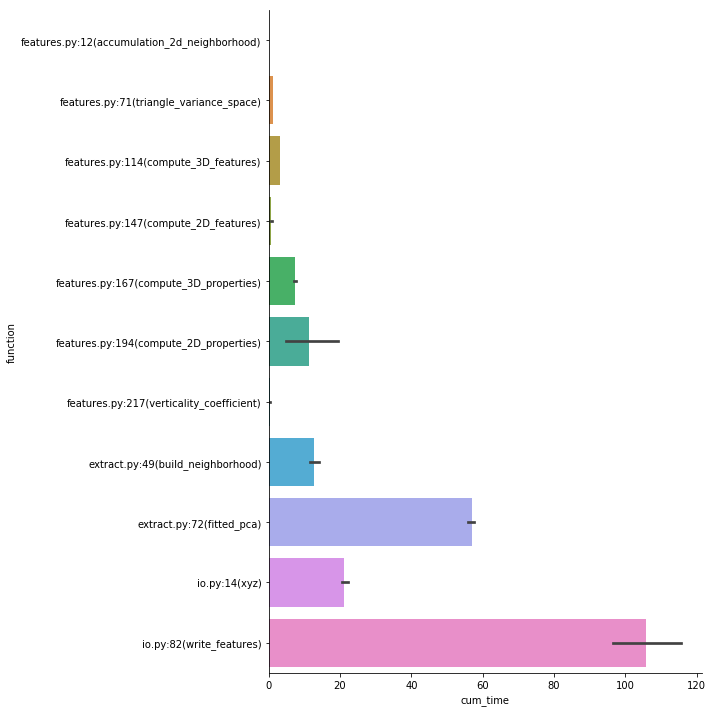

In [50]:
g = sns.catplot("cum_time", "function", data=graph_timers, kind="bar", size=10, height=2)

In [51]:
g.savefig("../docs/images/generation_feature_cum_time.png")

### Temps par itération

In [44]:
graph_iter_functions = ["extract.py:72(fitted_pca)",
                        "features.py:71(triangle_variance_space)",
                        "extract.py:49(build_neighborhood)",
                        "features.py:114(compute_3D_features)",
                        "features.py:147(compute_2D_features)",
                        "features.py:167(compute_3D_properties)",
                        "features.py:194(compute_2D_properties)",
                        "features.py:217(verticality_coefficient)"]

In [45]:
graph_iter_mask = np.logical_and(timers["feature_set"] == "full",
                                 [f in graph_iter_functions for f in timers["function"]])
graph_iter_timers = timers.loc[graph_iter_mask]
graph_iter_timers.drop(["feature_set"], axis=1, inplace=True)

/home/rde/.virtualenvs/univers/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


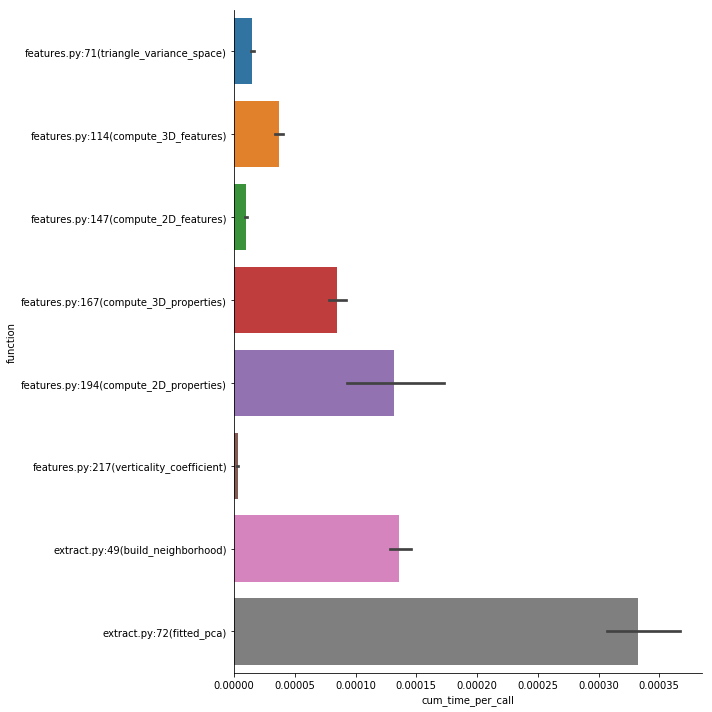

In [46]:
g = sns.catplot("cum_time_per_call", "function", data=graph_iter_timers, kind="bar", size=10, height=2)

In [49]:
g.savefig("../docs/images/generation_feature_cum_time_per_call.png")